In [1]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('CartPole-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, done, _, info = self.env.step(action)

        #一局游戏最多走N步
        self.step_n += 1
        if self.step_n >= 200:
            done = True

        return state, reward, done, info


env = MyWrapper()

env.reset()

array([ 0.00117849, -0.02656633, -0.03983996, -0.04204907], dtype=float32)

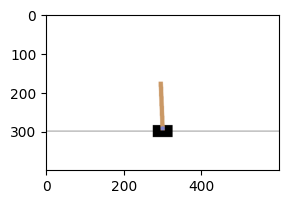

In [2]:
from matplotlib import pyplot as plt

%matplotlib inline


#打印游戏
def show():
    plt.figure(figsize=(3, 3))
    plt.imshow(env.render())
    plt.show()


show()

In [3]:
#认识游戏环境
def test_env():
    print('env.observation_space=', env.observation_space)
    print('env.action_space=', env.action_space)

    state = env.reset()
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    print('state=', state)
    print('action=', action)
    print('next_state=', next_state)
    print('reward=', reward)
    print('done=', done)


test_env()

env.observation_space= Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
env.action_space= Discrete(2)
state= [ 0.02599936  0.02100583 -0.04802375 -0.0343578 ]
action= 1
next_state= [ 0.02641948  0.21678238 -0.04871091 -0.34179762]
reward= 1.0
done= False


In [4]:
#测试torch.distributions.Categorical
def test_dist():
    import torch

    #创建分布
    dist = torch.distributions.Categorical(torch.FloatTensor([0.1, 0.2, 0.7]))

    #从分布中采样
    action = dist.sample()
    print('action=', action)

    #计算概率的log
    log_prob = dist.log_prob(action)
    print('log_prob=', log_prob)


test_dist()

action= tensor(1)
log_prob= tensor(-1.6094)


In [5]:
import torch

#定义模型
class Model(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.sequential = torch.nn.Sequential(torch.nn.Linear(4, 16),
                                              torch.nn.ReLU(),
                                              torch.nn.Linear(16, 2),
                                              torch.nn.Softmax(dim=1))

    def forward(self, state):
        #[4] -> [1, 4]
        state = torch.FloatTensor(state).unsqueeze(0)

        #计算当前state下各个动作的概率
        #[1, 4] -> [1, 2]
        probs = self.sequential(state)

        #以概率创建分布
        dist = torch.distributions.Categorical(probs)

        #在概率中采样,获得action
        #scala
        action = dist.sample()

        #求动作的概率对数
        #scala
        log_prob = dist.log_prob(action)

        return action.item(), log_prob


model = Model()
model([1, 2, 3, 4])

(1, tensor([-0.4004], grad_fn=<SqueezeBackward1>))

In [6]:
#测试概率和loss之间的关系
def test_loss(p0):
    #以概率创建分布
    dist = torch.distributions.Categorical(torch.FloatTensor([p0, 1 - p0]))

    log_probs = []
    for _ in range(1000):
        #在概率中采样,获得action
        action = dist.sample()

        #求动作的概率对数
        log_prob = dist.log_prob(action)

        log_probs.append(log_prob)

    #动作的概率,取值是0-1,取对数后是-inf到0,符号取反之后是0到inf
    #这意味着loss越接近0,动作的概率越高,loss越大,动作的概率越低
    #动作本身也是从概率采样而来,所以概率越倾斜,loss越小.
    #也就是说[0.5,0.5]将导致大loss, [0.0,1.0]将导致小loss
    log_probs = torch.FloatTensor(log_probs)
    log_probs = -log_probs
    loss = log_probs.sum().item()

    return loss


for i in [0.5, 0.9, 0.9999]:
    print(i, test_loss(i))

0.5 693.1473388671875
0.9 318.4913024902344
0.9999 0.100021593272686


In [7]:
from IPython import display
import random


#测试一局游戏,得到reward_sum
def test(play=False):
    state = env.reset()
    reward_sum = 0
    done = False

    while not done:
        action, _ = model(state)
        state, reward, done, _ = env.step(action)
        reward_sum += reward

        if play and random.random() < 0.2:
            display.clear_output(wait=True)
            show()

    return reward_sum


sum([test() for _ in range(20)]) / 20

19.65

In [8]:
#训练
def train():
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    #训练N局游戏
    for i in range(5000):
        #得到一局游戏的数据
        rewards = []
        log_probs = []
        state = env.reset()
        done = False
        while not done:
            action, log_prob = model(state)
            state, reward, done, _ = env.step(action)

            #记录下rewards和log_probs
            rewards.append(reward)
            log_probs.append(log_prob)

        #[steps]
        rewards = torch.FloatTensor(rewards)
        #[steps]
        log_probs = torch.cat(log_probs)

        #对rewards进行decay后求和
        decay = torch.arange(len(rewards))
        #这里gamma写1.0意味着不decay
        decay = 1.0**decay
        rewards *= decay
        rewards = rewards.sum()

        #考虑rewards和log_probs两部分loss,让两者相乘即可
        loss = rewards * -log_probs.sum()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 200 == 0:
            print(i, sum([test() for _ in range(5)]) / 5)

    torch.save(model, 'save/3.Reinforce_CartPole')


#train()

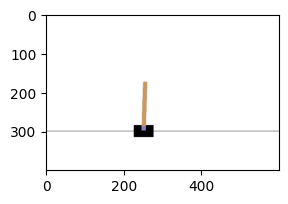

200.0

In [9]:
model = torch.load('save/3.Reinforce_CartPole')

#试玩
test(play=True)